In [1]:
import datetime
import json
import warnings

import numpy as np
import rasterio
import requests
import stac
import wtss
import xarray as xr
from pyproj import CRS, Proj, transform
from rasterio.windows import Window

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from eocube import EOCube, info, config

warnings.filterwarnings("ignore")

config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"

In [2]:
info.collections()

stac("https://brazildatacube.dpi.inpe.br/stac/")

In [3]:
info.describe("CB4_64_16D_STK-1")

name,common_name,min,max,nodata,scale,data_type
BAND13,blue,0.0,10000.0,-9999.0,0.0001,int16
BAND14,green,0.0,10000.0,-9999.0,0.0001,int16
BAND15,red,0.0,10000.0,-9999.0,0.0001,int16
BAND16,nir,0.0,10000.0,-9999.0,0.0001,int16
CLEAROB,ClearOb,1.0,255.0,0.0,1.0,uint8
CMASK,quality,0.0,4.0,255.0,1.0,uint8
EVI,evi,-10000.0,10000.0,-9999.0,0.0001,int16
NDVI,ndvi,-10000.0,10000.0,-9999.0,0.0001,int16
PROVENANCE,Provenance,1.0,366.0,-1.0,1.0,int16
TOTALOB,TotalOb,1.0,255.0,0.0,1.0,uint8


In [2]:
%%time
# https://www.keene.edu/campus/maps/tool/
bbox = [-46.4879608, -23.4298590, -46.0917664, -23.6891758]

eocube_service = EOCube(
    collections=["CB4_64_16D_STK-1"],
    query_bands=['red', 'green', 'blue', 'nir', 'ndvi'],
    bbox=bbox,
    start_date="2000-01-01",
    end_date="2021-01-01",
    limit=50
)

CPU times: user 139 ms, sys: 5.74 ms, total: 145 ms
Wall time: 4.76 s


In [3]:
classify = eocube_service.classifyDifference(
    band='red', start_date='2017-01-01', end_date='2019-01-01',
    limiar_min=-50, limiar_max=50
)

In [4]:
classify

<xarray.DataArray ['ClassifyDifference'] (time: 1, y: 428, x: 647)>
array([[[1, 1, 1, ..., 1, 1, 1],
        [2, 1, 1, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]])
Coordinates:
  * time     (time) <U41 '2018-10-16 00:00:00 - 2019-01-01 00:00:00'
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646

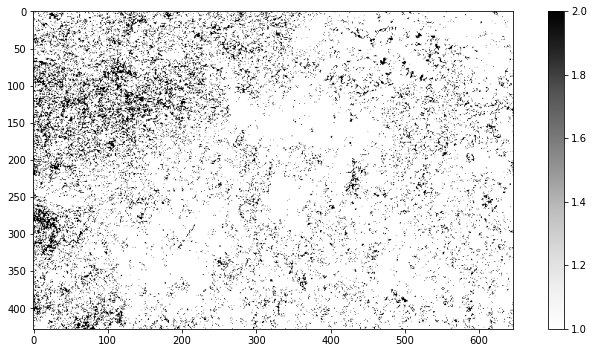

In [8]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greys', 1000)
plt.imshow(
    classify.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [4]:
%%time
time_series = eocube_service.getTimeSeries('ndvi', -46.2411118, -23.5674487)
time_series

CPU times: user 4.06 s, sys: 720 ms, total: 4.78 s
Wall time: 47.1 s


<xarray.DataArray ['TimeSeriesndvi'] (time: 50)>
array([ 4513,  6252,  3353,  6715,  5969,  7049,  5128,  1069,  4901,
        6355,  5811,  6729,  6997,  6467,  6952,  6915,  4702,  5698,
        6073,  1575,  5589,  5583,  6180,  6670,   846,  6455,  7116,
        6539,  4902,  6868,  4028,  6540,  6465,  6832,  6039,  6475,
        6632,  5666,  6603,  6001, -9999,  6838,  6822,  6271,  6876,
        6033,  4774,  6939,  4491,  2740], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16 2018-11-01 ... 2021-01-01
Attributes:
    longitude:  -46.2411118
    latitude:   -23.5674487

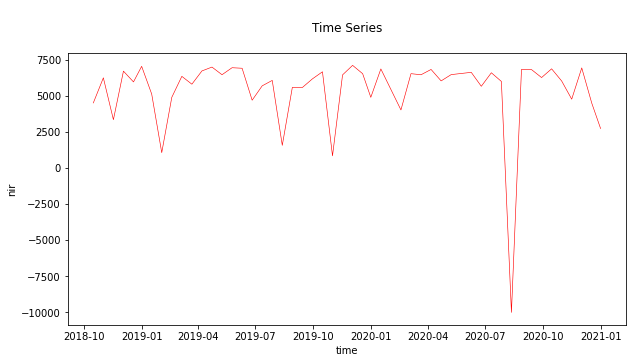

In [5]:
x = time_series.time
y = time_series

plt.figure(figsize=(10,5))
plt.title(f"\nTime Series\n")
plt.xlabel('time')
plt.ylabel('nir')
plt.plot(x, y, color="red", linewidth=0.6)
plt.show()

In [22]:
eocube_service.interactPlot('nir')

interactive(children=(Dropdown(description='date', options=(datetime.datetime(2018, 10, 16, 0, 0), datetime.da…

In [7]:
ndwi = eocube_service.calculateNDWI('2018-01-01')
ndwi

<xarray.DataArray ['ImageNDWI'] (time: 1, y: 428, x: 647)>
array([[[-0.47929859, -0.48840445, -0.52952247, ..., -0.46447338,
         -0.43647799, -0.47682386],
        [-0.46756367, -0.4897413 , -0.53101504, ..., -0.54330048,
         -0.51029748, -0.51188723],
        [-0.43969246, -0.49622857, -0.52784277, ..., -0.46796495,
         -0.4963145 , -0.51818951],
        ...,
        [-0.60099379, -0.56590293, -0.55094131, ..., -0.54547837,
         -0.52214765, -0.52883117],
        [-0.57267951, -0.58927277, -0.59441257, ..., -0.56824513,
         -0.55752212, -0.57422222],
        [-0.54846811, -0.59357231, -0.61201259, ..., -0.59405724,
         -0.58420336, -0.5913884 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646
Attributes:
    CB4_64_16D_STK-1:  CBERS-4 - AWFI - Cube Stack 16 days - v001

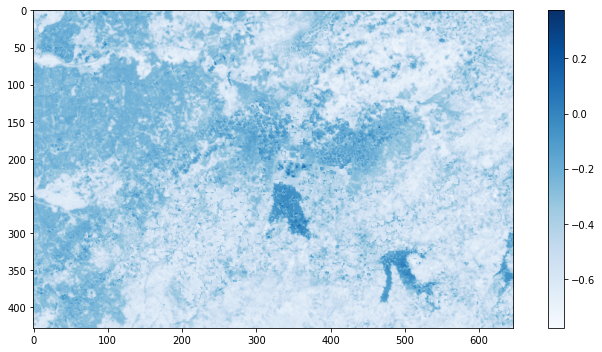

In [8]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Blues', 1000)
plt.imshow(
    ndwi.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [8]:
rgb = eocube_service.calculateColorComposition('2018-01-01')
rgb

<xarray.DataArray ['ColorComposition'] (time: 1, y: 428, x: 647, rgb: 3)>
array([[[[0.12738343, 0.16345566, 0.13731092],
         [0.16696042, 0.16865443, 0.12571429],
         [0.1251402 , 0.1529052 , 0.11798319],
         ...,
         [0.15494312, 0.17920489, 0.13277311],
         [0.18346419, 0.20550459, 0.16789916],
         [0.17545265, 0.19847095, 0.18588235]],

        [[0.15574427, 0.16941896, 0.14302521],
         [0.1496555 , 0.17492355, 0.1297479 ],
         [0.12578112, 0.15259939, 0.11495798],
         ...,
         [0.14725204, 0.16651376, 0.12823529],
         [0.16712065, 0.17996942, 0.14067227],
         [0.16391604, 0.17737003, 0.15697479]],

        [[0.17336965, 0.17828746, 0.14184874],
         [0.12562089, 0.16850153, 0.13294118],
         [0.12497997, 0.15428135, 0.11411765],
         ...,
...
         ...,
         [0.10639321, 0.13256881, 0.12571429],
         [0.10575228, 0.13608563, 0.12773109],
         [0.10591251, 0.13868502, 0.12789916]],

        [[0.10559205, 0.13058104, 0.09848739],
         [0.10126582, 0.12996942, 0.10907563],
         [0.0823586 , 0.12431193, 0.09764706],
         ...,
         [0.10927736, 0.14220183, 0.1302521 ],
         [0.10991828, 0.14525994, 0.13226891],
         [0.11200128, 0.14648318, 0.13193277]],

        [[0.11905143, 0.13746177, 0.10302521],
         [0.10350905, 0.12568807, 0.11008403],
         [0.08315975, 0.12247706, 0.09865546],
         ...,
         [0.10767505, 0.14204893, 0.12487395],
         [0.10719436, 0.14006116, 0.12319328],
         [0.10655344, 0.14220183, 0.12722689]]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646
  * rgb      (rgb) <U5 'red' 'green' 'blue'
Attributes:
    CB4_64_16D_STK-1:  CBERS-4 - AWFI - Cube Stack 16 days - v001

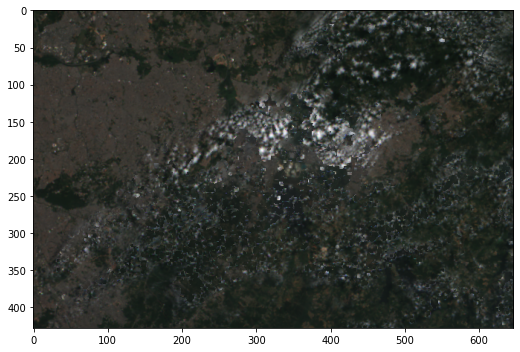

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(rgb.values[0])
plt.tight_layout()

plt.show()

In [30]:
ndvi = eocube_service.calculateNDVI('2010-01-01')
ndvi

<xarray.DataArray ['ImageNDVI'] (time: 1, y: 428, x: 647)>
array([[[0.58507307, 0.50976241, 0.61259921, ..., 0.53643337,
         0.49901553, 0.53981929],
        [0.5171386 , 0.5629387 , 0.6116745 , ..., 0.6003479 ,
         0.55360582, 0.5567591 ],
        [0.46934772, 0.61350752, 0.61433869, ..., 0.52591093,
         0.54112189, 0.57274321],
        ...,
        [0.65698123, 0.65391621, 0.67523923, ..., 0.63233666,
         0.6223176 , 0.63318535],
        [0.65334035, 0.67763326, 0.72291105, ..., 0.66403941,
         0.65955335, 0.67036076],
        [0.61160481, 0.66606358, 0.73017936, ..., 0.68888889,
         0.67828805, 0.68975974]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646
Attributes:
    CB4_64_16D_STK-1:  CBERS-4 - AWFI - Cube Stack 16 days - v001

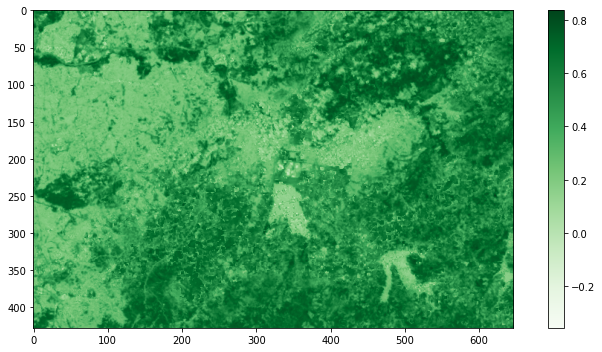

In [31]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(
    ndvi.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()